In [13]:
import os
import sys
import umap

import numpy as np
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from core.data.utils import read_all_datasets, read_all_metadata
from core.data.processing.normalization import robust_zscore_normalization_per_dataset
from core.stats.tests import test_two_groups
from core.utils.genes import entrez_id_to_gene_symbol

In [16]:
DATA_DIR = '../../db'
ENRICHR_LIBRARIES = ['WikiPathway_2023_Human']

In [26]:
dataset, dataset_label = read_all_datasets(DATA_DIR, dropna=False)

In [29]:
dataset = entrez_id_to_gene_symbol(dataset)

4975 input query terms found no hit:	['100127886', '100127940', '100127972', '100127974', '100128046', '100128175', '100128185', '1001281


In [27]:
metadata = read_all_metadata(DATA_DIR)

In [28]:
metadata['inflammation'] = np.where(pd.isna(metadata['inflammation']) & (metadata['disease'] == 'UC'), 'Inflamed', metadata['inflammation'])
metadata['inflammation'] = np.where(pd.isna(metadata['inflammation']) & (metadata['disease'] == 'Ctrl'), 'Uninflamed', metadata['inflammation'])

In [30]:
y = metadata[(((metadata.disease == 'UC') & (metadata.inflammation == 'Inflamed')) | ((metadata.disease == 'Ctrl') & (metadata.inflammation == 'Uninflamed'))) & metadata.time_of_biopsy.isin([None, 'W0', 'Before', np.nan])].disease
dataset_labels = dataset_label.loc[y.index]
X = dataset.loc[y.index]
# X = X.dropna(axis=1)

X.shape, y.shape

((946, 25032), (946,))

In [6]:
X_norm = robust_zscore_normalization_per_dataset(X, dataset_label)

In [7]:
X_norm = entrez_id_to_gene_symbol(X_norm)

13 input query terms found no hit:	['10638', '129790', '157247', '158295', '23285', '26148', '285464', '401052', '55410', '79686', '807


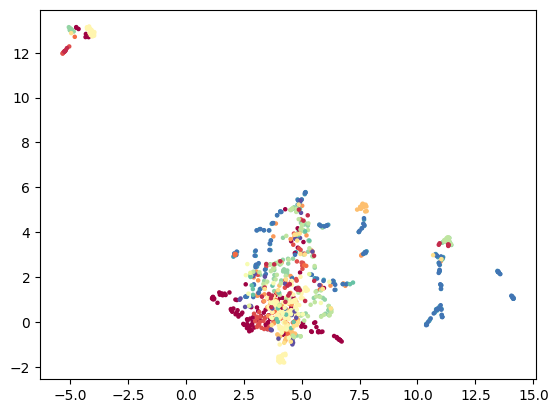

In [8]:
umap_embedding = umap.UMAP().fit_transform(X_norm)

plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=pd.Categorical(dataset_labels).codes, cmap='Spectral', s=5)
plt.show()

In [9]:
test_data = X_norm.astype(float)
test_data['disease'] = y

test_results = test_two_groups(test_data, 'disease', alpha=0.05/test_data.shape[1])

Test results for disease:
Group counts: 300 | 646
- BACE2: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.868
- SAMD9L: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.7388
- C4BPB: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.6912
- UBE2L6: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.8261
- APOL2: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.7554
- ATPAF1: [Mann-Whitney U test] p-value = 0.0; mean difference = -0.7897
- DAPP1: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.8092
- APOL1: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.7876
- CXCL8: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.7887
- OLFM4: [Mann-Whitney U test] p-value = 0.0; mean difference = 1.2427
- TMEM98: [Mann-Whitney U test] p-value = 0.0; mean difference = -0.6616
- IL1RN: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.8339
- PARP9: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.7422
- AFG3L2: [Mann-Whitne

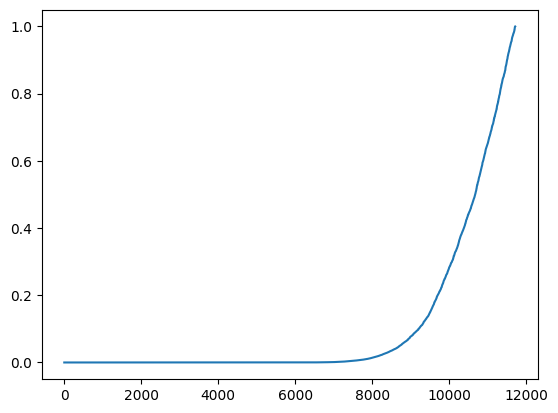

In [10]:
plt.plot([p for f, (p, d, t) in test_results]);

In [11]:
genes = [f for f, (p, d, t) in test_results if p < 0.05/test_data.shape[1]]

In [12]:
# libraries = gp.get_library_name(organism='Human')
# print(libraries)

gene_list = genes[:500]

enrichr_results = gp.enrichr(gene_list=gene_list, gene_sets=ENRICHR_LIBRARIES, organism='Human', outdir='../../results/enrichr_kegg', cutoff=0.05)

/usr/local/anaconda3/envs/ibd/lib/python3.11/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


In [13]:
enrichr_results.res2d[enrichr_results.res2d['Adjusted P-value'] < 0.05].sort_values('Combined Score', ascending=False).head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
1,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,7/19,2.272550e-07,0.000042,0,0,23.058824,352.735275,HADHA;CPT1A;SLC22A5;CPT2;ECI1;ACADM;ACSF2
6,WikiPathway_2023_Human,Mitochondrial Long Chain Fatty Acid Beta Oxida...,6/17,2.319470e-06,0.000170,0,0,21.518955,279.190618,HADHA;CPT1A;CPT2;ECI1;ACADM;ACSF2
0,WikiPathway_2023_Human,Type II Interferon Signaling WP619,10/37,1.656642e-08,0.000008,0,0,14.718821,263.700748,SOCS3;SOCS1;NOS2;STAT1;IL1B;IRF1;TAP1;JAK2;GBP...
28,WikiPathway_2023_Human,Nanomaterial Induced Inflammasome Activation W...,3/7,5.043180e-04,0.008737,0,0,29.420523,223.369541,IL1B;CASP1;TLR4
47,WikiPathway_2023_Human,Arachidonic Acid AA ARA Oxylipin Metabolism WP...,2/4,3.619519e-03,0.034727,0,0,39.152610,220.093038,EPHX2;TBXAS1
14,WikiPathway_2023_Human,Immune Response To Tuberculosis WP4197,6/22,1.257205e-05,0.000429,0,0,14.790486,166.896350,IFITM1;SOCS1;STAT1;IRF1;TAP1;JAK2
13,WikiPathway_2023_Human,miRNA Targets In ECM And Membrane Receptors WP...,6/22,1.257205e-05,0.000429,0,0,14.790486,166.896350,COL3A1;COL1A2;COL4A2;COL4A1;COL5A2;COL6A3
3,WikiPathway_2023_Human,Lung Fibrosis WP3624,11/63,4.066747e-07,0.000042,0,0,8.413088,123.800712,RTEL1;CEBPB;CXCL8;CCL11;PLAU;IL1B;SPP1;TIMP1;C...
2,WikiPathway_2023_Human,Burn Wound Healing WP5055,12/74,2.807556e-07,0.000042,0,0,7.709413,116.302518,COL1A1;CXCL8;COL1A2;IL1B;TNC;PECAM1;CXCL1;TIMP...
17,WikiPathway_2023_Human,7 Oxo C And 7 Beta HC Pathways WP5064,6/27,4.485191e-05,0.001276,0,0,11.266050,112.797316,CYP27A1;ACOT9;ACOT8;ACOX2;EPHX2;ACOT11


In [9]:
test_data = X.astype(float)
test_data['disease'] = y

In [32]:
# Now let's try the same analysis but for each dataset separately

test_data = X.astype(float)
test_data['disease'] = y

all_test_results = []
all_enrichment_results = pd.DataFrame()
for dataset_name in dataset_labels.unique():
    print()
    print(dataset_name)
    datset_test_data = test_data[dataset_labels == dataset_name]

    if datset_test_data.shape[0] < 5:
        print('Skipping dataset', dataset_name, 'because of small sample size')
        continue

    if datset_test_data['disease'].nunique() < 2:
        print('Skipping dataset', dataset_name, 'because there is only one class present in the dataset')
        continue

    datset_test_results = test_two_groups(datset_test_data, 'disease', alpha=0.05/datset_test_data.shape[1])
    all_test_results.append((dataset_name, datset_test_results))
    
    genes = [f for f, (p, d, t) in datset_test_results if p < 0.05/datset_test_data.shape[1]]

    gene_list = genes[:500]

    if len(gene_list) == 0:
        print('No significant genes found for dataset', dataset_name)
        continue

    enrichr_results = gp.enrichr(gene_list=gene_list, gene_sets=ENRICHR_LIBRARIES, organism='Human', cutoff=0.05)

    enrichr_results.res2d[enrichr_results.res2d['Adjusted P-value'] < 0.05].sort_values('Combined Score', ascending=False)
    enrichr_results.res2d['dataset'] = dataset_name
    enrichr_results.res2d['rank'] = range(1, len(enrichr_results.res2d) + 1)
    all_enrichment_results = pd.concat([all_enrichment_results, enrichr_results.res2d])


GSE87466
Test results for disease:
Group counts: 0 | 0
- CNTN4: [t-test] p-value = 0.0; mean difference = -0.9405
- BMAL2: [t-test] p-value = 0.0; mean difference = 1.3212
- NPY1R: [t-test] p-value = 0.0; mean difference = -2.6266
- AMACR: [t-test] p-value = 0.0; mean difference = -1.2233
- ANKH: [t-test] p-value = 0.0; mean difference = -0.6866
- IRAK3: [t-test] p-value = 0.0; mean difference = 1.4021
- COL6A3: [t-test] p-value = 0.0; mean difference = 1.6009
- SERF1B: [t-test] p-value = 0.0; mean difference = -1.1227
- ACSF2: [t-test] p-value = 0.0; mean difference = -2.0135
- UBE2L6: [t-test] p-value = 0.0; mean difference = 1.256
- VCAM1: [t-test] p-value = 0.0; mean difference = 1.3401
- SERF1A: [t-test] p-value = 0.0; mean difference = -1.1921
- IFI16: [t-test] p-value = 0.0; mean difference = 1.4112
- RPS6KA6: [t-test] p-value = 0.0; mean difference = -1.0725
- C1QTNF3: [t-test] p-value = 0.0; mean difference = -1.0049
- RBPMS: [t-test] p-value = 0.0; mean difference = 0.8268
-

In [45]:
# Now let's order the pathways by their mean position in the ranking
all_enrichment_results['rank'] = all_enrichment_results['rank'].astype(int)
all_enrichment_results.groupby('Term')['rank'].mean().sort_values().head(50)

Term
Alternative Pathway Of Fetal Androgen Synthesis WP4524                                                           2.000000
Mineralocorticoid Biosynthesis WP5279                                                                            3.000000
Glucocorticoid Biosynthesis WP5280                                                                               4.000000
Mitochondrial Long Chain Fatty Acid Beta Oxidation WP368                                                         5.571429
Mitochondrial Fatty Acid Oxidation Disorders WP5123                                                              5.714286
Vitamins A And D Action Mechanisms WP4342                                                                       14.000000
Autophagy In Pancreatic Ductal Adenocarcinoma WP5331                                                            28.000000
IDO Metabolic Pathway WP5414                                                                                    31.000000
TCA Cycle Aka Krebs

In [48]:
all_enrichment_results[all_enrichment_results['Term'] == 'Mitochondrial Fatty Acid Oxidation Disorders WP5123']

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,dataset,rank
0,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,7/19,2.272550e-07,0.000114,0,0,23.058824,352.735275,HADHB;CPT1A;SLC22A5;CPT2;SLC25A20;ACADS;ACSF2,GSE87466,1
1,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,5/19,8.325675e-05,0.020190,0,0,14.059163,132.065893,PECR;CPT1A;ACADM;SLC25A20;ACADS,GSE75214,2
10,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,3/19,1.117082e-02,0.448919,0,0,7.350604,33.036924,HADHA;ECI1;ACSF2,GSE11223,11
1,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,7/19,2.272550e-07,0.000059,0,0,23.058824,352.735275,SLC22A5;CPT2;ECI1;ACADM;SLC25A20;HADH;ACADS,GSE179285,2
0,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,7/19,2.272550e-07,0.000114,0,0,23.058824,352.735275,HADHB;CPT1A;SLC22A5;CPT2;SLC25A20;ACADS;ACSF2,GSE92415,1
0,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,7/19,2.272550e-07,0.000101,0,0,23.058824,352.735275,HADHB;PECR;CPT1A;SLC22A5;ACADM;SLC25A20;ACADS,GSE73661,1
21,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,3/19,1.117082e-02,0.242711,0,0,7.350604,33.036924,SCP2;ECI1;ACADM,GSE16879,22


In [17]:
dataset_labels.value_counts()

dataset
GSE48634     137
GSE11223     132
GSE87466     108
GSE92415     108
GSE75214      96
GSE73661      79
GSE179285     54
GSE23597      45
GSE3629       43
GSE16879      36
GSE9452       26
GSE36807      22
GSE22619      20
GSE87465      19
GSE52746      17
GSE72780       4
Name: count, dtype: int64

In [49]:
foa_genes = np.unique(sum([g.split(';') for g in all_enrichment_results[all_enrichment_results['Term'] == 'Mitochondrial Fatty Acid Oxidation Disorders WP5123'].Genes], []))

foa_genes

array(['ACADM', 'ACADS', 'ACSF2', 'CPT1A', 'CPT2', 'ECI1', 'HADH',
       'HADHA', 'HADHB', 'PECR', 'SCP2', 'SLC22A5', 'SLC25A20'],
      dtype='<U8')

In [19]:
all_results = pd.DataFrame()
for dr in all_test_results:
    asdf = pd.DataFrame([[g, p, m] for g, (p, m, t) in dr[1]])
    asdf['dataset'] = dr[0]
    all_results = pd.concat([all_results, asdf])

all_results.columns = ['gene', 'p', 'diff', 'dataset']

significant_results = all_results[all_results['p'] < 0.05/all_results.shape[0]]

significant_foa_genes = significant_results[significant_results['gene'].isin(foa_genes)]

(significant_foa_genes['diff'] < 0).value_counts()

diff
True    53
Name: count, dtype: int64

# Experiments with normalization

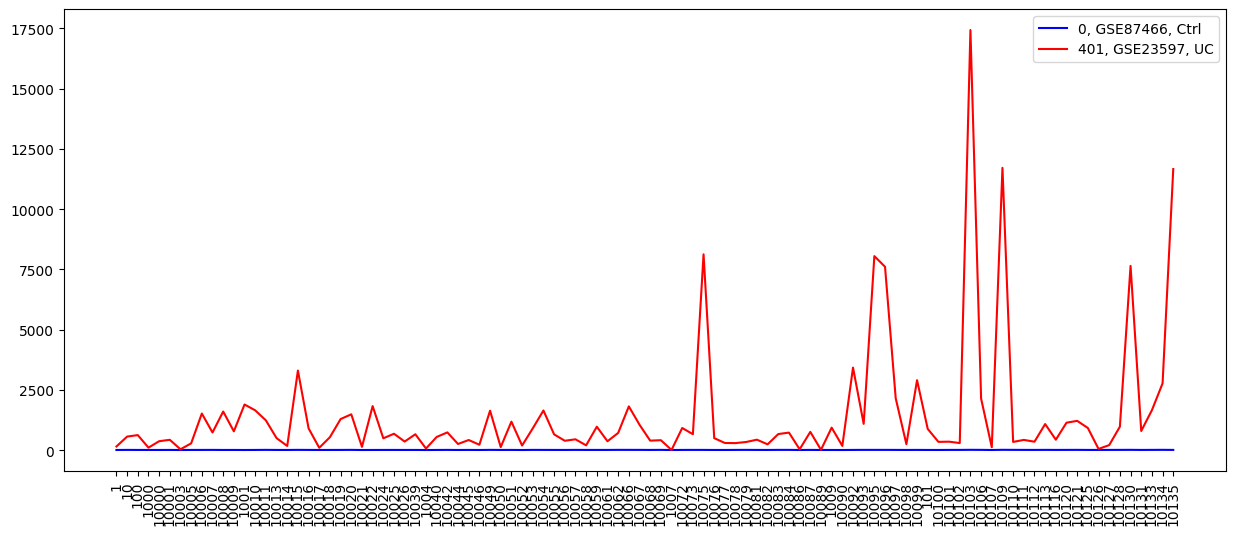

In [20]:
idx_0 = 0
idx_1 = 401
start_feature = 000
end_feature = 100
sample_0 = X.dropna(axis=1).iloc[idx_0, start_feature:end_feature]
sample_1 = X.dropna(axis=1).iloc[idx_1, start_feature:end_feature]

plt.figure(figsize=(15, 6));
plt.plot(sample_0, 'b');
plt.plot(sample_1, 'r');
plt.xticks(rotation=90);
plt.legend([f'{idx_0}, {dataset_labels.iloc[idx_0]}, {y.iloc[idx_0]}', f'{idx_1}, {dataset_labels.iloc[idx_1]}, {y.iloc[idx_1]}']);

/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_1383/4239693137.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(y[idx_0])
/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_1383/4239693137.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(y[idx_1])


Ctrl
UC


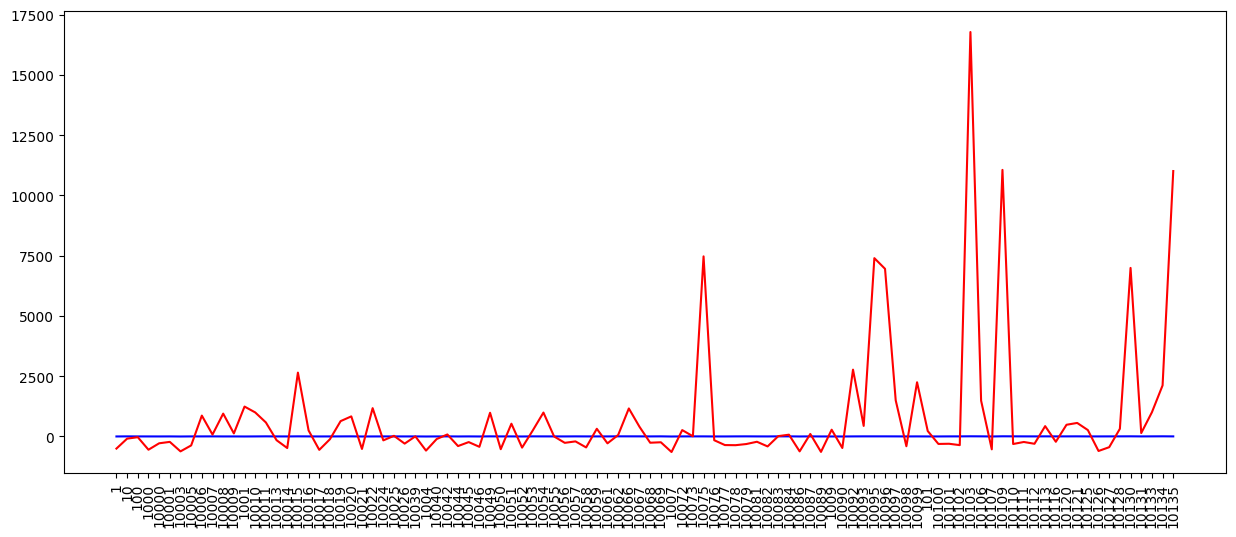

In [21]:
median_0, median_1 = sample_0.median(), sample_1.median()

plt.figure(figsize=(15, 6));
plt.plot(sample_0 - median_0, 'b');
print(y[idx_0])
plt.plot(sample_1 - median_1, 'r');
print(y[idx_1])
plt.xticks(rotation=90);

/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_1383/224693890.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(y[idx_0])
/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_1383/224693890.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(y[idx_1])


Ctrl
UC


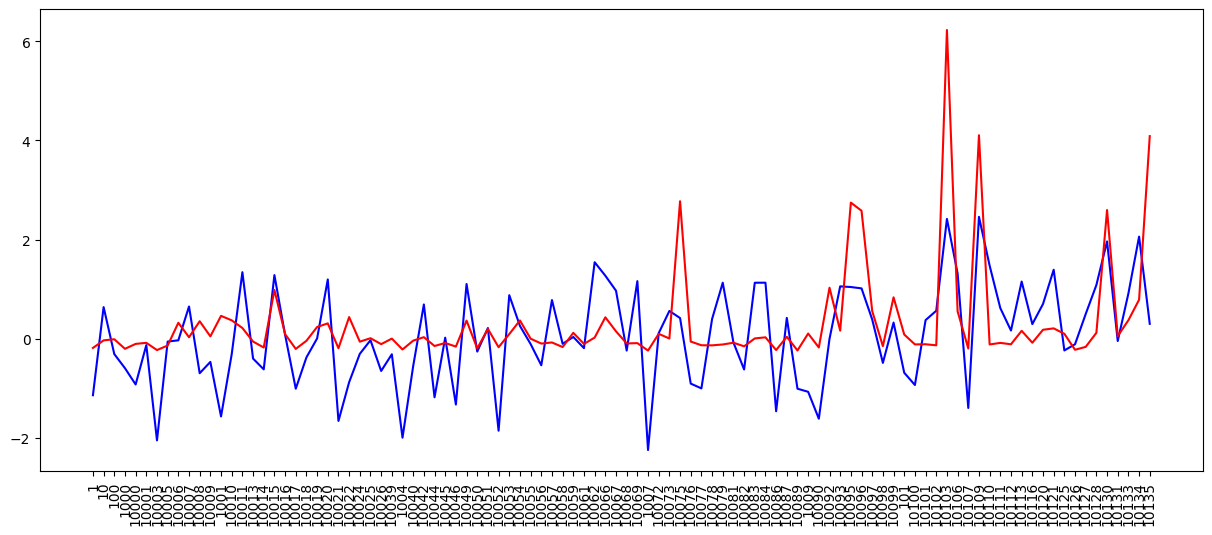

In [22]:
median_0, median_1 = sample_0.median(), sample_1.median()

sample_0_norm = (sample_0 - median_0)/(sample_0.std())
sample_1_norm = (sample_1 - median_1)/(sample_1.std())

plt.figure(figsize=(15, 6));
plt.plot(sample_0_norm, 'b');
print(y[idx_0])
plt.plot(sample_1_norm, 'r');
print(y[idx_1])
plt.xticks(rotation=90);

In [23]:
X[dataset_labels == dataset_labels.iloc[idx_0]]

ENTREZ_ID,1,10,100,1000,10000,10001,10003,10005,10006,10007,...,9982,9984,9985,9987,9988,9989,999,9991,9993,9997
GSM2332098,5.2325,8.4981,6.75725,6.23450,5.630017,7.090350,3.55884,7.22025,7.266633,8.5195,...,9.7306,10.1286,5.41285,8.624583,8.0785,6.86930,8.81225,8.28792,8.365767,9.8530
GSM2332099,5.4705,9.8179,7.49160,6.21240,5.500817,7.136125,3.52456,8.44875,7.083900,9.2197,...,9.8615,9.3047,5.33010,8.266650,7.5423,7.36095,8.23635,7.97216,7.683633,10.7265
GSM2332100,5.2118,8.8066,6.68880,6.01155,5.719517,7.411625,3.62260,7.20005,7.257633,8.5008,...,8.7079,9.7405,5.30060,8.522667,8.4188,6.89725,9.05750,8.36268,8.291333,9.2246
GSM2332101,4.9717,8.9799,5.87125,5.97845,5.906933,7.746625,3.61452,7.12795,7.547600,8.2570,...,8.9751,9.6596,4.93170,8.575067,8.4622,6.99025,9.27975,8.56112,8.065533,9.2155
GSM2332102,4.9519,8.1933,5.72865,6.12670,5.534200,7.328075,3.68008,6.76040,7.168567,8.1799,...,9.6515,10.0796,5.49165,8.879417,8.3534,6.80605,8.97070,8.18936,8.473733,9.2611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM2332201,5.6986,6.5703,7.66595,6.57920,6.464017,7.372675,3.44812,5.98015,6.973833,8.1391,...,8.1324,10.0444,5.64225,8.963683,8.2503,7.49390,8.07175,8.06704,7.980033,9.0335
GSM2332202,5.3604,7.7002,7.37535,7.07555,6.689117,7.444400,3.69942,5.86400,7.109800,8.3044,...,9.3221,9.7257,5.20500,8.871500,8.2146,7.20910,8.53835,8.16316,7.963500,8.8109
GSM2332203,5.1196,8.2223,7.30290,5.97165,5.865683,7.346675,3.61314,6.48875,7.202933,8.8450,...,9.5051,9.6512,5.73050,8.700683,8.3351,7.34250,8.89855,8.12156,8.172367,9.1559
GSM2332204,5.4220,6.5480,8.21380,6.30200,5.793867,7.094650,3.64044,6.37085,6.459767,8.9613,...,9.6391,10.0387,5.94350,8.482883,8.0039,7.10275,8.41930,7.54544,8.370433,9.8370
